In [1]:
import os, pickle
from tqdm import tqdm  # Import tqdm for progress tracking
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm
import pyemma
import pyemma.coordinates as coor

## Load in important functions

In [4]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)
    

In [2]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

## Prepare the Data and make a new traj using state to indicate

In [4]:
save_dir = 'omega_data'
all_omega = Data.load(f"{save_dir}/data.pkl").array_list  # This is an (85, x, 3) array
# Convert each array in the list to float
all_omega = [arr.astype(float) for arr in all_omega]

# Apply omega2cistrans() to each array in all_omega
all_cistrans = [omega2cistrans(arr) for arr in all_omega]

# Print shape of the first converted array for verification
print(f"First array shape after conversion: {all_cistrans[0].shape}")

First array shape after conversion: (80085, 3)


In [10]:
# Find the minimum x-dimension across all arrays
max_x = max(arr.shape[0] for arr in all_cistrans)

print(f"larges x in all_cistrans: {max_x}")

all_cistrans

larges x in all_cistrans: 196095


[array([[1, 0, 1],
        [1, 0, 1],
        [1, 0, 1],
        ...,
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]]),
 array([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        ...,
        [1, 0, 1],
        [1, 0, 1],
        [1, 0, 1]]),
 array([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        ...,
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]]),
 array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]),
 array([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]),
 array([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]),
 array([[0, 1, 1],
        [0, 1, 1],
        [0, 1, 1],
        ...,
        [1, 1, 0],
        [1, 1, 0],
        [1, 1, 0]]),
 array([[1, 1, 0],
        [1, 1, 0],
        [1, 1, 0],
        ...,
        [1, 0, 1],
        

## Make transition matrix 

In [ ]:
def state_to_index(state):
    """Converts a (3,) binary state array into an index (0-7)."""
    state = np.asarray(state)  # Ensure input is a NumPy array
    
    if state.shape != (3,):  # Ensure exactly 3 elements
        raise ValueError(f"Unexpected state shape: {state.shape}, expected (3,). State: {state}")
    
    if not np.all((state == 0) | (state == 1)):  # Ensure only binary values
        raise ValueError(f"State contains non-binary values: {state}")
    
    # Convert 3 binary values into an integer (0-7)
    binary_index = int("".join(map(str, state.astype(int))), 2)

    return binary_index

def index_to_state(index):
    """Converts an index (0-7) into a (3,) binary state array."""
    if not (0 <= index < 8):  # Ensure valid range (0-7)
        raise ValueError(f"Index out of range: {index}. Expected 0-7.")

    # Convert index to a 3-bit binary string
    binary_str = format(index, '03b')  # Example: 3 -> '011'
    
    # Convert binary string to NumPy array of integers
    state = np.array([int(bit) for bit in binary_str], dtype=int)

    return state



def get_transition_matrix(traj, num_states, lagtime, pseudocount=0.25):
    """Returns a row-normalized transition matrix T for a given lagtime (in steps) for a single traj."""
    
    C = np.zeros((num_states, num_states))  # Count matrix

    N = len(traj)  # Number of time steps for this trajectory

    for t in range(0, N - lagtime):
        from_state = traj[t]  # Directly use index
        to_state = traj[t + lagtime]  # Directly use index

        # Count transitions
        C[from_state, to_state] += 1.0

    # Add pseudocounts to avoid zero entries
    C += pseudocount

    # Normalize rows to get probabilities
    T = C / C.sum(axis=1, keepdims=True)

    return T


def decomposition_transition_state(T, lagtime=1):
    """Return the implied timescale and the corresponding eigenvector.
    
    INPUT
    T       - Transition matrix where T_ij is the probability of transitioning i -> j in lagtime.
    
    PARAMETERS
    lagtime - Lagtime used to build T (in units of steps). Default = 1.
    num_states - Number of states 
    
    RETURN
    v1      - The right eigenvector corresponding to the slowest non-stationary mode.
    """
    try:

        # Compute the stationary state composition 
        n_states = T.shape[0]
        A = np.transpose(T) - np.eye(n_states)
        A = np.vstack([A, np.ones(n_states)])
        b = np.zeros(n_states + 1)
        b[-1] = 1
        pi, *_ = np.linalg.lstsq(A, b, rcond=None)
        
    except Exception as e:
        pi = None
        print(f"Error computing implied timescale: {e}")

    return pi


In [8]:
def state_to_index_vectorized(all_cistrans):
    """
    Converts a list of (3,) binary state arrays into indices (0-7),
    while preserving NaN values.
    """
    all_cistrans_array = np.array(all_cistrans, dtype=float)  # Allow NaN values

    if all_cistrans_array.ndim != 3 or all_cistrans_array.shape[-1] != 3:
        raise ValueError(f"Unexpected shape: {all_cistrans_array.shape}, expected (N, M, 3)")

    # Create a mask for NaN values
    nan_mask = np.isnan(all_cistrans_array).any(axis=-1)  # Shape: (N, M)

    # Convert binary states to indices where values are not NaN
    binary_weights = np.array([4, 2, 1])  # Weights for binary conversion (2^2, 2^1, 2^0)
    
    # Initialize the output array with NaN values
    indexed_states = np.full(all_cistrans_array.shape[:-1], np.nan)  # Shape: (N, M)

    # Apply binary conversion only to non-NaN rows
    valid_mask = ~nan_mask
    indexed_states[valid_mask] = np.dot(all_cistrans_array[valid_mask], binary_weights)

    return indexed_states  # Output is a 2D array of indices, with NaNs preserved

def index_to_state(index):
    """Converts an index (0-7) into a (3,) binary state array."""
    if not (0 <= index < 8):  # Ensure valid range (0-7)
        raise ValueError(f"Index out of range: {index}. Expected 0-7.")

    # Convert index to a 3-bit binary string
    binary_str = format(index, '03b')  # Example: 3 -> '011'
    
    # Convert binary string to NumPy array of integers
    state = np.array([int(bit) for bit in binary_str], dtype=int)

    return state

In [21]:
import numpy as np

def get_transition_matrix(traj, num_states, lagtime, pseudocount=0.25):
    """Returns a row-normalized transition matrix T for a given lagtime (in steps) while handling NaN values."""
    
    C = np.zeros((num_states, num_states))  # Count matrix

    N = len(traj)  # Number of time steps for this trajectory

    for t in range(0, N - lagtime):
        from_state = traj[t]
        to_state = traj[t + lagtime]

        # Skip transitions involving NaN
        if np.isnan(from_state) or np.isnan(to_state):
            continue

        # Convert to integer for indexing
        from_state = int(from_state)
        to_state = int(to_state)

        # Count transitions
        C[from_state, to_state] += 1.0

    # Add pseudocounts to avoid zero entries
    C += pseudocount

    # Normalize rows to get probabilities (avoid division by zero)
    row_sums = C.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Prevent division by zero for states with no transitions
    T = C / row_sums

    return T


In [22]:
import numpy as np

def compute_stationary_distribution(T):
    """Compute the stationary distribution of a transition matrix T.
    
    INPUT:
    T - Transition matrix where T_ij is the probability of transitioning i -> j.
    
    RETURN:
    pi - The stationary distribution (1D NumPy array).
    """
    try:
        # Ensure no NaNs in T
        if np.isnan(T).any():
            raise ValueError("Transition matrix contains NaN values.")

        # Compute the stationary state distribution 
        n_states = T.shape[0]
        A = np.transpose(T) - np.eye(n_states)  # (T' - I)
        A = np.vstack([A, np.ones(n_states)])  # Append normalization row
        b = np.zeros(n_states + 1)
        b[-1] = 1  # Ensure probability sums to 1
        
        # Solve for stationary distribution using least squares
        pi, *_ = np.linalg.lstsq(A, b, rcond=None)
        
        # Ensure non-negative values and normalize
        pi = np.maximum(pi, 0)  # Prevent small negative values due to numerical error
        pi /= np.sum(pi)  # Normalize to sum to 1

    except Exception as e:
        print(f"Error computing stationary distribution: {e}")
        pi = None

    return pi


In [ ]:
ntraj = len(all_omega)

# Find the longest traj
maxlength = max( [ len(all_cistrans[i]) for i in range(ntraj) ])
print('maxlength', maxlength)

# Make an array to store all the trajectories
traj = np.nan * np.ones( (ntraj, maxlength, 3) )

for i in range(ntraj):
    n = len(all_cistrans[i])
    traj[i, 0:n, :] = all_cistrans[i]

traj


maxlength 196095


array([[[ 1.,  0.,  1.],
        [ 1.,  0.,  1.],
        [ 1.,  0.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       ...,

       [[ 1.,  1.,  0.],
        [ 1.,  1.,  0.],
        [ 1.,  1.,  0.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[ 1.,  0.,  1.],
        [ 1.,  0.,  1.],
        [ 1.,  0.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]

In [17]:
print('traj.shape', traj.shape)

traj_indexed = state_to_index_vectorized(traj)

traj.shape (742, 196095, 3)


In [20]:
print('traj_indexed.shape', traj_indexed.shape)

traj_indexed.shape (742, 196095)


In [23]:
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm

# Parameters
pseudocount = 0.25
num_states = 8
lagtimes = [5, 10, 25, 50] + list(range(100, 80000, 5000))
dt_in_ns = 0.01  

# Store results
pi_all_means = []
pi_all_uppers = []
pi_all_lowers = []
pi_all_stds = []

def process_trajectory(traj, lagtime):
    """Compute the stationary distribution for a given trajectory."""
    T = get_transition_matrix(traj, num_states, lagtime, pseudocount)  # Compute transition matrix
    pi = compute_stationary_distribution(T)  # Compute stationary distribution
    return pi

# Loop over lagtimes and compute stationary distributions
for lagtime in tqdm(lagtimes, desc="Processing Lag Times", unit="lag"):
    # Parallel computation across all trajectories
    pi_all = Parallel(n_jobs=-1, backend='loky')(delayed(process_trajectory)(traj, lagtime) for traj in traj_indexed)
    
    # Convert to NumPy array (shape: (n_trajectories, num_states))
    pi_all = np.array(pi_all)
    
    # Compute mean, std, upper, and lower bounds
    pi_means = np.nanmean(pi_all, axis=0)  # Mean across trajectories
    pi_std = np.nanstd(pi_all, axis=0)  # Standard deviation
    pi_uppers = pi_means + pi_std  # Upper bound
    pi_lowers = pi_means - pi_std  # Lower bound

    # Append to results
    pi_all_means.append(pi_means)
    pi_all_uppers.append(pi_uppers)
    pi_all_lowers.append(pi_lowers)
    pi_all_stds.append(pi_std)

# Convert to NumPy arrays
pi_all_means = np.array(pi_all_means)
pi_all_uppers = np.array(pi_all_uppers)
pi_all_lowers = np.array(pi_all_lowers)
pi_all_stds = np.array(pi_all_stds)
lagtimes_ns = np.array(lagtimes) * dt_in_ns

# Print final shapes
print("pi_all_means.shape:", pi_all_means.shape)  # (n_lagtimes, num_states)
print("pi_all_stds.shape:", pi_all_stds.shape)    # (n_lagtimes, num_states)


Processing Lag Times: 100%|██████████| 20/20 [37:50<00:00, 113.52s/lag]

pi_all_means.shape: (20, 8)
pi_all_stds.shape: (20, 8)


In [28]:
# Create an instance of Data with your arrays
data_instance = Data([pi_all_means, pi_all_uppers, pi_all_lowers, pi_all_stds, lagtimes_ns])

# Save to a file
data_instance.save("autocoorel_data/stationary_distributions.pkl")

In [10]:
omega_loaded = Data.load("autocoorel_data/stationary_distributions.pkl").array_list
pi_all_means = omega_loaded[0]
pi_all_uppers = omega_loaded[1]
pi_all_lowers = omega_loaded[2]
pi_all_stds = omega_loaded[3]
lagtimes_ns = omega_loaded[4]

pi_all_means


array([[0.08325281, 0.0735084 , 0.07267553, 0.07086297, 0.16446874,
        0.21513384, 0.15717464, 0.16292307],
       [0.08292299, 0.07439241, 0.07285886, 0.07098748, 0.16258236,
        0.21591877, 0.15647748, 0.16385964],
       [0.08268178, 0.0758732 , 0.07323997, 0.07166615, 0.16080616,
        0.21592831, 0.15570667, 0.16409776],
       [0.08264758, 0.07694682, 0.07369522, 0.07234972, 0.16010664,
        0.21522537, 0.15524711, 0.16378155],
       [0.08265419, 0.07776608, 0.07420037, 0.07272414, 0.15966267,
        0.2144366 , 0.15510948, 0.16344648],
       [0.08319254, 0.07736751, 0.07875872, 0.06882435, 0.15987732,
        0.21097946, 0.15424971, 0.16675039],
       [0.0949879 , 0.08083942, 0.08404631, 0.07007467, 0.15856395,
        0.19865059, 0.15277053, 0.16006664],
       [0.09419768, 0.08636566, 0.08909694, 0.07755104, 0.15971126,
        0.18926964, 0.14741323, 0.15639454],
       [0.09548262, 0.08985086, 0.0910707 , 0.08198087, 0.15910767,
        0.1868916 , 0.141325

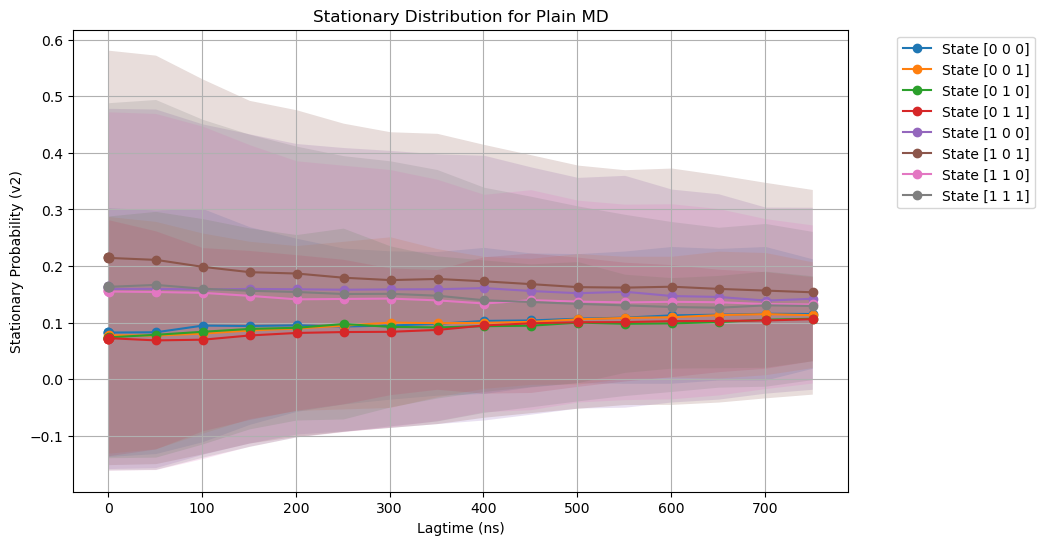

In [9]:
plt.figure(figsize=(10, 6))
state_to_plot = range(8)  # Fix: Select states 0 to 7

# Loop through selected states and plot each separately
for i, state in enumerate(state_to_plot):
    plt.plot(lagtimes_ns, pi_all_means[:, i], '-o', label=f'State {index_to_state(state)}')
        
    # Add shaded region for standard deviation
    plt.fill_between(lagtimes_ns, 
                     pi_all_means[:, i] + pi_all_stds[:, i],  # Upper bound
                     pi_all_means[:, i] - pi_all_stds[:, i],  # Lower bound
                     alpha=0.2)

plt.xlabel('Lagtime (ns)')
plt.ylabel('Stationary Probability (v2)')
plt.title('Stationary Distribution for Plain MD')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.grid(True)
plt.show()
